In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
!pip install -U openai-whisper



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 41.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s e

In [ ]:
import whisper


In [ ]:
import torch
import torchvision
import torchaudio
import tensorflow as tf
import transformers

In [ ]:
import librosa
import cv2
import torchaudio

Installed all the tools and libraries for the running of model


Phase 1 – Unimodal Pipelines
Audio CNN:
Convert audio to spectrograms or MFCCs :
Here I chose spectograms because of good visualisation and good functionality with CNNs.

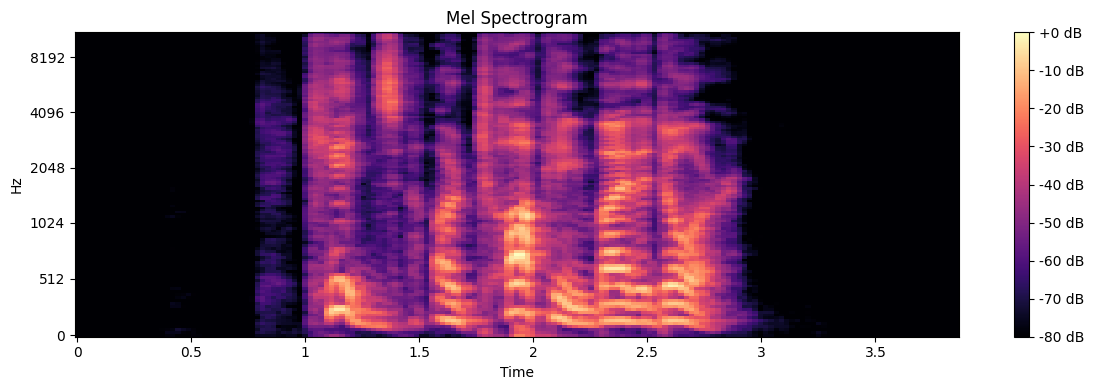

In [ ]:
# Plot one spectrogram for an audio file for understanding the working of spectrogram and librosa
file_path = '/content/drive/MyDrive/ravdess_data/Actor_01/03-01-05-01-01-01-01.wav'



y, sr = librosa.load(file_path, sr=22050)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale for visualization


plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=512,
                         x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()


In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [ ]:
data_dir = '/content/drive/MyDrive/ravdess_data'
# Defines the emotion map as per file names of audio clips for training CNN
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# extracts the emtion label for file map by file name for training
def extract_emotion_from_audio_clip(filename):
    emotion_code = filename.split('-')[2]
    emotion_string = emotion_map.get(emotion_code)
    return emotion_string

# converts audio clip into mel spectrogram for feeding into CNN
# sample rate defines how many audio samples per second are captured from the continuous sound wave
# n_mels defines the number of rows in the Mel spectrogram i.e how many frequency bands the audio is divided into.
# max_frames is the number of time frames in the mel spectrpgram

def audio_to_melspectrogram(filepath , sample_rate = 22050,num_mels = 128 , max_frames = 862):
    y , _ = librosa.load(filepath,sr=sample_rate) # loads audio at a fixed sample rate
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_mels=num_mels) # y is waveform audio time series
    mel_spec_db = librosa.power_to_db(mel_spectrogram, ref=np.max) # converts to decibels after converting to spectrogram
    # pad or truncate to fixed size - ensure all sprectrograms have exactly max_frames columns(time dimension)
    if mel_spec_db.shape[1] < max_frames:
        pad_width = max_frames - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, pad_width=((0,0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :max_frames]

    return mel_spec_db

# dataset processing
X = []
y = []

for root, dirs, files in os.walk(data_dir):
    for file in tqdm(files):
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            try:
                label = extract_emotion_from_audio_clip(file)
                if label is None:
                    continue
                mel_spec = audio_to_melspectrogram(file_path)
                X.append(mel_spec)
                y.append(label)
            except Exception as e:
                print(f"Error processing {file}: {e}")

# convert to numpy arrays for feeding to CNN
X = np.array(X)
X = X[..., np.newaxis]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = np.array(y_encoded)

np.save("X_spectrograms.npy", X)
np.save("y_labels.npy", y_encoded)
np.save("label_classes.npy", label_encoder.classes_)


0it [00:00, ?it/s]
  0%|          | 0/60 [00:00<?, ?it/s]Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7cbcf268ce00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/llvmlite/binding/executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 
  2%|▏         | 1/60 [00:03<03:22,  3.44s/it]

Error processing 03-01-03-01-01-02-19.wav: no compiled object yet for <Library '_localmax' at 0x7cbce43de590>


 12%|█▏        | 7/60 [00:07<00:55,  1.05s/it]


KeyboardInterrupt: 

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

# Load your data
X = np.load('X_spectrograms.npy')
y = np.load('y_labels.npy')

X = np.transpose(X, (0, 3, 1, 2)) # CNNs expect inputs in shape (N, Channels, Height, Width)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create dataset and split
dataset = TensorDataset(X_tensor, y_tensor) # pairs each spectrogram with label
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size]) # 80% training data and 20% testing data

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# Define CNN
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(64, num_classes) # maps 64 extracted features to number of emoton classes

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x) # data flows through CNN , flattened and passed through classifier

# Initialize model
num_classes = len(np.unique(y)) # 8 unique classes
cnn_model = EmotionCNN(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)



for epoch in range(10):
    # Training the model
    cnn_model.train()
    total_loss = 0
    train_correct, train_total = 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad() # clears old gradients
        out = cnn_model(xb) # forward pass
        loss = criterion(out, yb)
        loss.backward() # computes gradients and update weights
        optimizer.step()

        total_loss += loss.item()
        preds = out.argmax(dim=1)
        train_correct += (preds == yb).sum().item()
        train_total += yb.size(0)

    train_accuracy = train_correct / train_total

    # Evaluation of the model
    cnn_model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = cnn_model(xb)
            preds = out.argmax(dim=1)
            test_correct += (preds == yb).sum().item()
            test_total += yb.size(0)

    test_accuracy = test_correct / test_total

    # Outputting epochs and their trainign and test accuracies
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2%}, Test Accuracy: {test_accuracy:.2%}")
    print("Audio CNN Done!")


NameError: name 'np' is not defined

Text RNN : Generate transcripts from the audio using Whisper. Train an RNN like GRU on these transcripts to classify emotions.

In [ ]:

import json

# Initialize whisper model for transcription
model = whisper.load_model("base")

data_dir = "/content/drive/MyDrive/ravdess_data"
transcripts = {}  # Dictionary to store transcripts

# Walk through all folders and transcribe each .wav file
for root, dirs, files in os.walk(data_dir):
    for dir_name in dirs:
        # Print which actor's files are being processed
        print(f"Transcribing actor: {dir_name}")

        # Now loop through files in each actor's folder
        actor_folder = os.path.join(root, dir_name)  # Get full path of actor folder
        for file in os.listdir(actor_folder):
            if file.endswith(".wav"):
                filepath = os.path.join(actor_folder, file)

                try:
                    # Perform transcription using Whisper
                    result = model.transcribe(filepath)
                    transcripts[file] = result["text"]

                except Exception as e:
                    print(f"Failed to transcribe {file}: {e}")

# Save all the transcripts to a JSON file
with open("ravdess_data_transcripts.json", "w") as f:
    json.dump(transcripts, f, indent=2)

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 76.5MiB/s]


Transcribing actor: Actor_19
Transcribing actor: Actor_21
Transcribing actor: Actor_20
Transcribing actor: Actor_17
Transcribing actor: Actor_15
Transcribing actor: Actor_18
Transcribing actor: Actor_22
Transcribing actor: Actor_23
Transcribing actor: Actor_24
Transcribing actor: Actor_16
Transcribing actor: Actor_06
Transcribing actor: Actor_13
Transcribing actor: Actor_10
Transcribing actor: Actor_07
Transcribing actor: Actor_14
Transcribing actor: Actor_11
Transcribing actor: Actor_05
Transcribing actor: Actor_08
Transcribing actor: Actor_09
Transcribing actor: Actor_12
Transcribing actor: Actor_04
Transcribing actor: Actor_01
Transcribing actor: Actor_03
Transcribing actor: Actor_02


Here all the actors are talking the same thing again and again . Kids are talking by the door. (or) Dogs are sitting by the door. So by the dataset transcripts , it is useless to train an RNN (though some exclamation marks suggest some difference) exactly with those transcripts. So here we should simulate some sentences based on emotion labels and add them to text transcripts for training. Otherwise there is no valuable information that can be obtained.


In [ ]:

import json

# Load existing transcripts
with open("ravdess_data_transcripts.json", "r") as file:
    transcripts = json.load(file)

# Simulated sentences that are added to the text transcripts to gain valuable info
simulated = {
    "neutral": "I am neutral to things",
    "calm": "I am very calm now. ",
    "happy": "I am very happy!!!!",
    "sad": "I am feeling somewhat sad and depressed. I will talk later",
    "angry": "I am very angry!! Don't irritate me!",
    "fearful": "I'm very scared and nervous.",
    "disgust": "Ewww!! What a disgusting thing you have done!",
    "surprised": "Wow! What a sudden surprise!"
}

# Add simulated sentences
for filename in transcripts:
    try:
        emotion_code = filename.split("-")[2]
        emotion = emotion_map.get(emotion_code)
        if emotion:
            transcripts[filename] += " " + simulated[emotion]
    except Exception as e:
        print(f"Could not process {filename}: {e}")

# Save back to file
with open("ravdess_data_transcripts_simulated.json", "w") as f:
    json.dump(transcripts, f, indent=2)

Now it is time for training the RNN model with the obtained transcripts.


In [ ]:
import torch.nn as nn
import json
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')


# Load transcripts into a dictionary
with open('/content/ravdess_data_transcripts_simulated.json', 'r') as file:
    transcripts = json.load(file)

texts = []
labels = []
# Convert it into 2 separate lists of texts and labels for training and evaluation
for filename, text in transcripts.items():
    emotion_id = filename.split('-')[2]  # 3rd token is emotion code
    emotion = emotion_map.get(emotion_id)
    if emotion:
        texts.append(text.lower())
        labels.append(emotion)

# Tokenize the strings for processing the data of transcripts
tokenized_texts = [word_tokenize(t) for t in texts]

# Builds a  vocabulary
all_words = [word for tokens in tokenized_texts for word in tokens] # flattens list of lists into single list of all words
word_freq = Counter(all_words) # counts how many times each word appears
vocab = {word: index + 2 for index, (word, _) in enumerate(word_freq.items())}
vocab['padding'] = 0 # useful for padding tokens
vocab['unknown'] = 1 # useful for representing unknown words

# Convert to index sequences
indexed_texts = [[vocab.get(word, 1) for word in tokens] for tokens in tokenized_texts]

# Pad sequences
padded_texts = pad_sequence([torch.tensor(sequence) for sequence in indexed_texts], batch_first=True, padding_value=0)

# Used for label encoding
label_encoder = LabelEncoder()
encoded_labels = torch.tensor(label_encoder.fit_transform(labels))


X_train, X_test, y_train, y_test = train_test_split(padded_texts, encoded_labels, test_size=0.2, random_state=42)

class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X # padded token sequences
        self.y = y # encoded emotion classes
    def __len__(self):
        return len(self.X) # number of samples in dataset
    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_ds = EmotionDataset(X_train, y_train)
test_ds = EmotionDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)



class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__() # Converts each word index into a dense vector of size embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        # Fully connected (dense) layer for classification.

        # Takes the final hidden state of the GRU and outputs class scores (one for each emotion class).
    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        return self.fc(hidden.squeeze(0))

vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 128
num_classes = len(label_encoder.classes_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_model = GRUClassifier(vocab_size, embed_dim, hidden_dim, num_classes).to(device)



criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

# Train and test the model (similar to CNN model for the above cell)
for epoch in range(10):
    # Training the model
    rnn_model.train()
    total_loss = 0
    train_correct, train_total = 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = rnn_model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(output, dim=1)
        train_correct += (preds == yb).sum().item()
        train_total += yb.size(0)

    train_accuracy = train_correct / train_total

    # Evaluation of the model
    rnn_model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = rnn_model(xb)
            preds = torch.argmax(output, dim=1)
            test_correct += (preds == yb).sum().item()
            test_total += yb.size(0)

    test_accuracy = test_correct / test_total

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, "
          f"Training Accuracy: {train_accuracy:.2%}, Testing Accuracy: {test_accuracy:.2%}")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch 1, Loss: 1.3968, Training Accuracy: 58.59%, Testing Accuracy: 81.25%
Epoch 2, Loss: 0.3010, Training Accuracy: 90.36%, Testing Accuracy: 100.00%
Epoch 3, Loss: 0.0408, Training Accuracy: 100.00%, Testing Accuracy: 100.00%
Epoch 4, Loss: 0.0107, Training Accuracy: 100.00%, Testing Accuracy: 100.00%
Epoch 5, Loss: 0.0060, Training Accuracy: 100.00%, Testing Accuracy: 100.00%
Epoch 6, Loss: 0.0041, Training Accuracy: 100.00%, Testing Accuracy: 100.00%
Epoch 7, Loss: 0.0030, Training Accuracy: 100.00%, Testing Accuracy: 100.00%
Epoch 8, Loss: 0.0023, Training Accuracy: 100.00%, Testing Accuracy: 100.00%
Epoch 9, Loss: 0.0019, Training Accuracy: 100.00%, Testing Accuracy: 100.00%
Epoch 10, Loss: 0.0016, Training Accuracy: 100.00%, Testing Accuracy: 100.00%


Now we have successfully completed Phase - 1. Unimodal pipelines. Now it is time for combining both visual features from CNN and text features from RNN using fusion techniques like early fusion and late fusion.

Early fusion process means concatenating the embeddings before classification.Data from multiple modalities (e.g., text, audio, video, images) are combined at the input or feature level, before being passed into the main model for learning or prediction.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from nltk.tokenize import word_tokenize
import json
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')

# Load transcripts into a dictionary
with open('/content/ravdess_data_transcripts_simulated.json', 'r') as file:
    transcripts = json.load(file)

texts = []
labels = []
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}
# Extract emtion code and then add them accordingly
for filename, text in transcripts.items():
    emotion_id = filename.split('-')[2]  # 3rd token is emotion code
    emotion = emotion_map.get(emotion_id)
    if emotion:
        texts.append(text.lower())
        labels.append(emotion)

# Tokenize the text transcripts for processing
tokenized_texts = [word_tokenize(t) for t in texts]

# Builds a  vocabulary
all_words = [word for tokens in tokenized_texts for word in tokens]
word_freq = Counter(all_words)
vocab = {word: index + 2 for index, (word, _) in enumerate(word_freq.items())}
vocab['padding'] = 0 # token for padding
vocab['unknown'] = 1 # token for unknown words in vocabulary

# Convert to index sequences
indexed_texts = [[vocab.get(word, 1) for word in tokens] for tokens in tokenized_texts]

# Pad sequences before passing to RNN
padded_texts = pad_sequence([torch.tensor(sequence) for sequence in indexed_texts], batch_first=True, padding_value=0)

# label encoding done
label_encoder = LabelEncoder()
encoded_labels = torch.tensor(label_encoder.fit_transform(labels))

# load the spectrogram files already created in the above cell for audio CNN
X_audio = np.load('X_spectrograms.npy')
y_audio = np.load('y_labels.npy')

# Convert to tensors
X_audio_tensor = torch.tensor(X_audio, dtype=torch.float32)
y_audio_tensor = torch.tensor(y_audio, dtype=torch.long)

# split the text data into training dataset and testing dataset
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(padded_texts, encoded_labels, test_size=0.2, random_state=42)

# split the audio data into training dataset and testing dataset
X_train_audio, X_test_audio, y_train_audio, y_test_audio = train_test_split(X_audio_tensor, y_audio_tensor, test_size=0.2, random_state=42)

# create the dataset for fusion(early)
class FusionDataset(Dataset):
    def __init__(self, X_text, X_audio, y):
        self.X_text = X_text
        self.X_audio = X_audio
        self.y = y

    def __len__(self):
        return len(self.X_text)

    def __getitem__(self, index):
        return self.X_text[index], self.X_audio[index], self.y[index]

train_ds = FusionDataset(X_train_text, X_train_audio, y_train_text)
test_ds = FusionDataset(X_test_text, X_test_audio, y_test_text)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

class EarlyFusionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden, num_classes):
        super().__init__()
        # text RNN (GRU)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, rnn_hidden, batch_first=True)

        # audio CNN
        self.cnn = nn.Sequential(
            nn.Conv2d(128, 16, kernel_size=3, padding=1),  # adjusted for 128 input channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # added padding
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # compress the spatial dimensions to 1x1
        )


        # final classifier after early fusion
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden + 64, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, text, audio):
        # text
        embedded = self.embedding(text)
        _, hidden = self.gru(embedded)
        text_feat = hidden.squeeze(0)

        # audio
        audio_feat = self.cnn(audio)
        audio_feat = audio_feat.view(audio_feat.size(0), -1)

        # early fusion
        combined = torch.cat((text_feat, audio_feat), dim=1)

        return self.classifier(combined)

# Initialize model
vocab_size = len(vocab)
embed_dim = 100
rnn_hidden = 128
num_classes = len(label_encoder.classes_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
early_model = EarlyFusionModel(vocab_size, embed_dim, rnn_hidden, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# training the model after fusion
for epoch in range(10):
    early_model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for text_batch, audio_batch, labels_batch in train_loader:
        text_batch, audio_batch, labels_batch = text_batch.to(device), audio_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()

        # Forward pass
        output = early_model(text_batch, audio_batch)

        # Compute loss
        loss = criterion(output, labels_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # calculate training accuracy
        _, preds = torch.max(output, dim=1)
        correct_train += (preds == labels_batch).sum().item()
        total_train += labels_batch.size(0)

    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%")

# evaluating the model
early_model.eval()  # set the model to evaluation mode
correct_test = 0
total_test = 0
with torch.no_grad():  # no need to compute gradients during evaluation
    for text_batch, audio_batch, labels_batch in test_loader:
        text_batch, audio_batch, labels_batch = text_batch.to(device), audio_batch.to(device), labels_batch.to(device)

        output = early_model(text_batch, audio_batch)  # get model output

        # Calculate accuracy
        _, preds = torch.max(output, dim=1)
        correct_test += (preds == labels_batch).sum().item()
        total_test += labels_batch.size(0)

test_accuracy = 100 * correct_test / total_test  # Calculate test accuracy
print(f"Test Accuracy: {test_accuracy:.2f}%")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch 1, Loss: 2.0587, Training Accuracy: 16.41%
Epoch 2, Loss: 1.5395, Training Accuracy: 36.28%
Epoch 3, Loss: 1.3182, Training Accuracy: 40.97%
Epoch 4, Loss: 1.1277, Training Accuracy: 47.14%
Epoch 5, Loss: 0.9037, Training Accuracy: 56.86%
Epoch 6, Loss: 0.7458, Training Accuracy: 65.10%
Epoch 7, Loss: 0.6819, Training Accuracy: 70.14%
Epoch 8, Loss: 0.5456, Training Accuracy: 75.43%
Epoch 9, Loss: 0.2755, Training Accuracy: 95.66%
Epoch 10, Loss: 0.0866, Training Accuracy: 100.00%
Test Accuracy: 100.00%


Late fusion : average/logit voting. In this fusion technique , we combine both the outputs after each model has made its individual prediction.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from nltk.tokenize import word_tokenize
import json
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')

# Load transcripts into a dictionary
with open('/content/ravdess_data_transcripts_simulated.json', 'r') as file:
    transcripts = json.load(file)

texts = []
labels = []
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}
# Extract emtion code and then add them accordingly
for filename, text in transcripts.items():
    emotion_id = filename.split('-')[2]  # 3rd token is emotion code
    emotion = emotion_map.get(emotion_id)
    if emotion:
        texts.append(text.lower())
        labels.append(emotion)

# Tokenize the text transcripts for processing
tokenized_texts = [word_tokenize(t) for t in texts]

# Builds a  vocabulary
all_words = [word for tokens in tokenized_texts for word in tokens]
word_freq = Counter(all_words)
vocab = {word: index + 2 for index, (word, _) in enumerate(word_freq.items())}
vocab['padding'] = 0 # token for padding
vocab['unknown'] = 1 # token for unknown words in vocabulary

# Convert to index sequences
indexed_texts = [[vocab.get(word, 1) for word in tokens] for tokens in tokenized_texts]

# Pad sequences before passing to RNN
padded_texts = pad_sequence([torch.tensor(sequence) for sequence in indexed_texts], batch_first=True, padding_value=0)

# label encoding done
label_encoder = LabelEncoder()
encoded_labels = torch.tensor(label_encoder.fit_transform(labels))

# load the spectrogram files already created in the above cell for audio CNN
X_audio = np.load('X_spectrograms.npy')
y_audio = np.load('y_labels.npy')

# Convert to tensors
X_audio_tensor = torch.tensor(X_audio, dtype=torch.float32)
y_audio_tensor = torch.tensor(y_audio, dtype=torch.long)

# split the text data into training dataset and testing dataset
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(padded_texts, encoded_labels, test_size=0.2, random_state=42)

# split the audio data into training dataset and testing dataset
X_train_audio, X_test_audio, y_train_audio, y_test_audio = train_test_split(X_audio_tensor, y_audio_tensor, test_size=0.2, random_state=42)

# create the dataset for fusion(early)
class FusionDataset(Dataset):
    def __init__(self, X_text, X_audio, y):
        self.X_text = X_text
        self.X_audio = X_audio
        self.y = y

    def __len__(self):
        return len(self.X_text)

    def __getitem__(self, index):
        return self.X_text[index], self.X_audio[index], self.y[index]

train_ds = FusionDataset(X_train_text, X_train_audio, y_train_text)
test_ds = FusionDataset(X_test_text, X_test_audio, y_test_text)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# late fusion model
class LateFusionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden, num_classes):
        super(LateFusionModel, self).__init__()

        # text RNN (GRU)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, rnn_hidden, batch_first=True)

        self.cnn = nn.Sequential(
    nn.Conv2d(128, 16, kernel_size=3, padding=1),  # 128 input channels
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 1), stride=2, padding=0),  # adjusted pooling to avoid too much reduction in height
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 1), stride=2, padding=0),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1))  # output should have a fixed size of (1,1)
)



        # connected layers for late fusion
        self.text_fc = nn.Linear(rnn_hidden, 64)
        self.audio_fc = nn.Linear(64, 64)
        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(64 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, text, audio):
        # text
        embedded = self.embedding(text)
        _, hidden = self.gru(embedded)
        text_feat = hidden.squeeze(0)

        # audio
        audio_feat = self.cnn(audio)
        audio_feat = audio_feat.view(audio_feat.size(0), -1)

       # text and audio layers (fully connected)
        text_feat = self.text_fc(text_feat)
        audio_feat = self.audio_fc(audio_feat)

        # combine both output features
        combined = torch.cat((text_feat, audio_feat), dim=1)

        # final classifier
        return self.classifier(combined)

# initialise model
vocab_size = len(vocab)
embed_dim = 100
rnn_hidden = 128
num_classes = len(label_encoder.classes_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
late_model = LateFusionModel(vocab_size, embed_dim, rnn_hidden, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# training the model(similar  to early fusion thing)
for epoch in range(10):
    late_model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for text_batch, audio_batch, labels_batch in train_loader:
        text_batch, audio_batch, labels_batch = text_batch.to(device), audio_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()

        # Forward pass
        output = late_model(text_batch, audio_batch)

        # Compute loss
        loss = criterion(output, labels_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # calculate training accuracy
        _, preds = torch.max(output, dim=1)
        correct_train += (preds == labels_batch).sum().item()
        total_train += labels_batch.size(0)

    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%")

# evaluation of the model
late_model.eval()  # Set the model to evaluation mode
correct_test = 0
total_test = 0
with torch.no_grad():  # no need to compute gradients during evaluation
    for text_batch, audio_batch, labels_batch in test_loader:
        text_batch, audio_batch, labels_batch = text_batch.to(device), audio_batch.to(device), labels_batch.to(device)

        output = late_model(text_batch, audio_batch)

        # calculate accuracy
        _, preds = torch.max(output, dim=1)
        correct_test += (preds == labels_batch).sum().item()
        total_test += labels_batch.size(0)

test_accuracy = 100 * correct_test / total_test  # Calculate test accuracy
print(f"Test Accuracy: {test_accuracy:.2f}%")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch 1, Loss: 2.0724, Training Accuracy: 13.54%
Epoch 2, Loss: 1.9986, Training Accuracy: 18.14%
Epoch 3, Loss: 1.6924, Training Accuracy: 27.52%
Epoch 4, Loss: 1.6855, Training Accuracy: 26.56%
Epoch 5, Loss: 1.6543, Training Accuracy: 30.21%
Epoch 6, Loss: 1.2276, Training Accuracy: 44.97%
Epoch 7, Loss: 0.6036, Training Accuracy: 73.35%
Epoch 8, Loss: 0.2388, Training Accuracy: 87.67%
Epoch 9, Loss: 0.1579, Training Accuracy: 94.27%
Epoch 10, Loss: 0.0454, Training Accuracy: 99.39%
Test Accuracy: 99.65%


Using Audio Transformer Model AST (Bonus Phase)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split

# Loads the data files
X = np.load('X_spectrograms.npy')
y = np.load('y_labels.npy')
# splitting the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Convert to tensors
X_train_tensor = torch.tensor(X_train.squeeze(-1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.squeeze(-1), dtype=torch.float32) # squeeze makes it into 3d array from 4d otherwise giving error
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# loads the data
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# defines a class for AST model
class ASTModel(nn.Module):
    def __init__(self, num_classes=8):
        super(ASTModel, self).__init__()

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=128, nhead=8),
            num_layers=4
        )

        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch_size, 128, 862)
        # Permute to (862, batch_size, 128)
        x = x.permute(2, 0, 1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # global average pooling over sequence
        x = self.fc(x)
        return x

# initialize model , loss and optimizer
model = ASTModel(num_classes=8)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch_idx, (data_batch, target_batch) in enumerate(train_loader):
        data_batch, target_batch = data_batch.to(device), target_batch.to(device)

        optimizer.zero_grad()
        outputs = model(data_batch)
        loss = criterion(outputs, target_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == target_batch).sum().item()
        total_preds += target_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_preds / total_preds
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Accuracy = {train_acc:.2f}%")

    # Evaluation of te model
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data_batch, target_batch in test_loader:
            data_batch, target_batch = data_batch.to(device), target_batch.to(device)
            outputs = model(data_batch)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == target_batch).sum().item()
            test_total += target_batch.size(0)
    test_acc = 100 * test_correct / test_total
    print(f"Test Accuracy: {test_acc:.2f}%")
# saves the model in .pth file
torch.save(model.state_dict(), "ast_model.pth")


X_train_tensor shape: torch.Size([1152, 128, 862]), y_train_tensor shape: torch.Size([1152])
X_test_tensor shape: torch.Size([288, 128, 862]), y_test_tensor shape: torch.Size([288])
Unique labels: tensor([0, 1, 2, 3, 4, 5, 6, 7])
Max label: 7, Min label: 0
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Train Loss = 2.1975, Accuracy = 11.81%
Test Accuracy: 12.50%
Epoch 2: Train Loss = 2.1072, Accuracy = 13.63%
Test Accuracy: 12.50%
Epoch 3: Train Loss = 2.0848, Accuracy = 12.67%
Test Accuracy: 14.24%
Epoch 4: Train Loss = 2.0811, Accuracy = 12.15%
Test Accuracy: 12.50%
Epoch 5: Train Loss = 2.0830, Accuracy = 13.11%
Test Accuracy: 15.28%
Epoch 6: Train Loss = 2.0896, Accuracy = 12.41%
Test Accuracy: 15.28%
Epoch 7: Train Loss = 2.0914, Accuracy = 12.93%
Test Accuracy: 15.28%
Epoch 8: Train Loss = 2.0791, Accuracy = 12.85%
Test Accuracy: 14.24%
Epoch 9: Train Loss = 2.0786, Accuracy = 13.37%
Test Accuracy: 13.19%
Epoch 10: Train Loss = 2.0846, Accuracy = 14.06%
Test Accuracy: 13.54%


For using dependency managing tool poetry , refer to report.pdf for more details file for more details. Also for the further improvements , limitations , refer to it.